<a href="https://colab.research.google.com/github/SFauth/learning_scikit_learn/blob/main/tensorflow_influencer_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lerne TensorFlow (Deep Learning in Python)

Installieren der Pakete

In [ ]:
!pip install scikit-learn
!pip install tensorflow
!pip install plotly

Laden der Pakete

In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from google.colab import drive 
from sklearn.pipeline import Pipeline   
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PoissonRegressor

Festlegen des Arbeitsverzeichnisses

In [ ]:
drive.mount("/content/gdrive", force_remount=True)
%cd /content/gdrive/MyDrive/Learning_ML_and_AI/

Mounted at /content/gdrive
/content/gdrive/MyDrive/Learning_ML_and_AI


## Data Wrangling mit Pandas und Numpy

Einlesen der Daten mit Pandas

In [ ]:
df = pd.read_csv("influencer_data/top_insta_influencers_data.csv")
df.head(5)

,rank,channel_info,influence_score,posts,followers,avg_likes,60_day_eng_rate,new_post_avg_like,total_likes,country
0,1,cristiano,92,3.3k,475.8m,8.7m,1.39%,6.5m,29.0b,Spain
1,2,kyliejenner,91,6.9k,366.2m,8.3m,1.62%,5.9m,57.4b,United States
2,3,leomessi,90,0.89k,357.3m,6.8m,1.24%,4.4m,6.0b,NaN
3,4,selenagomez,93,1.8k,342.7m,6.2m,0.97%,3.3m,11.5b,United States
4,5,therock,91,6.8k,334.1m,1.9m,0.20%,665.3k,12.5b,United States


Welche Datentypen haben wir? Müssen wir was verändern?

In [ ]:
df.dtypes

rank                  int64
channel_info         object
influence_score       int64
posts                object
followers            object
avg_likes            object
60_day_eng_rate      object
new_post_avg_like    object
total_likes          object
country              object
dtype: object

Der Klassiker: viele Zahlen sind als String definiert, obwohl es Zahlen sind. Also sollten wir diese Spalten (Variablen) transformieren. 

In [ ]:
kmb_columns = ['avg_likes', 'posts', 'followers', 'new_post_avg_like', 'total_likes']

kmb_df = df[kmb_columns].replace({'k': '*1e3', 'm': '*1e6', 'b': '1e9'}, regex=True).applymap(pd.eval).astype(int)

kmb_df.head(5)

other_columns = df.drop(kmb_columns, axis=1)

df = pd.concat([other_columns, kmb_df], axis=1)

df.head(5)

,rank,channel_info,influence_score,60_day_eng_rate,country,avg_likes,posts,followers,new_post_avg_like,total_likes
0,1,cristiano,92,1.39%,Spain,8700000,3300,475800000,6500000,29010000000
1,2,kyliejenner,91,1.62%,United States,8300000,6900,366200000,5900000,57410000000
2,3,leomessi,90,1.24%,NaN,6800000,890,357300000,4400000,6010000000
3,4,selenagomez,93,0.97%,United States,6200000,1800,342700000,3300000,11510000000
4,5,therock,91,0.20%,United States,1900000,6800,334100000,665300,12510000000


Das Land ist auch noch nicht numerisch. Welche Werte kommen denn vor? Können wir das einfach als Dummy coden?

In [ ]:
df.country.value_counts().head(5)

United States    66
Brazil           13
India            12
Indonesia         7
France            6
Name: country, dtype: int64

Da wir zu viele Variablen bekommen würden, könnte man hier einfach sagen United States oder nicht.

In [ ]:
df['country'] = np.where(df['country'] == "United States", "US", "Not_US")

Nur noch 60 day engagement rate übrig!

In [ ]:
df['60_day_eng_rate'] = df['60_day_eng_rate'].str.rstrip('%').astype('float') / 100.0

Fertig ist unser Dataframe, den wir jetzt mit Scikit-Learn verarbeiten können! 

In [ ]:
df.head(5)

,rank,channel_info,influence_score,60_day_eng_rate,country,avg_likes,posts,followers,new_post_avg_like,total_likes
0,1,cristiano,92,0.0139,Not_US,8700000,3300,475800000,6500000,29010000000
1,2,kyliejenner,91,0.0162,US,8300000,6900,366200000,5900000,57410000000
2,3,leomessi,90,0.0124,Not_US,6800000,890,357300000,4400000,6010000000
3,4,selenagomez,93,0.0097,US,6200000,1800,342700000,3300000,11510000000
4,5,therock,91,0.0020,US,1900000,6800,334100000,665300,12510000000


Noch eine kurze graphische Übersicht: wir möchten den influence_score vorhersagen. Welche Werte kann dieser Score annehmen? 

In [ ]:
fig = px.histogram(df, x="influence_score", nbins=72)
fig.show()

Wir sehen, dass dieser Wert nur positive natürlich Zahlen (Integer) von 22 bis 93 annehmen kann. Daher macht hier kein Regressionsmodell Sinn, das den ganzen Raum aller reeller Zahlen vorhersagen kann, sondern ein Generalized Linear Model, das nur positive Integer vorhersagen kann. In unserem Fall können wir den influence_score als Poisson-verteilte Variable modellieren.
Man könnte auch darüber nachdenken, alle Werte unter 70 auszuschließen, da dass extreme Ausreißer sind, die das Training des Modells unnatürlich verschlechtern könnten.

## Scikit-Learn

Preprocessing Schritte definieren

In [ ]:
dummy_maker = Pipeline(steps=[
         ('dummy_coder', OneHotEncoder(sparse=False, drop='first', handle_unknown='ignore'))
        ])  

normalizer = Pipeline(steps=[
    ('standardizer', MinMaxScaler())
])

preprocessor = ColumnTransformer(
           transformers=[
             ('one_hot_encoder', dummy_maker, ['country']),
             ('scaler', normalizer, ['avg_likes', 'posts', 'followers', 'new_post_avg_like', 'total_likes'])
            ]
        )

Preprocessing anwenden und Zielvariable extrahieren

In [ ]:
X = pd.DataFrame(preprocessor.fit_transform(df))
# Minimales Beispiel für Theorie
# X = X.iloc[:, 0:3]

y = df['influence_score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=486)

1. Modell definieren

In [ ]:
model_1 = tf.keras.Sequential(
    [  
        layers.Dense(units=2, activation="relu", name='first_hidden_layer'),
        layers.Dense(units=2, activation="linear", name='second_hidden_layer'),
        layers.Dense(units=1, name='output_layer')]
)

2. Loss Function, die minimiert werden soll und Minimierungsverfahren wählen

In [ ]:
model_1.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.01))

3. Trainieren des Modells

In [ ]:
model_1.fit(X_train, y_train,
            validation_split = 0.2,
            epochs = 100,
            verbose = 0)

Zusammenfassung der Parameter

In [ ]:
model_1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_hidden_layer (Dense)  (32, 2)                   14        
                                                                 
 second_hidden_layer (Dense)  (32, 2)                  6         
                                                                 
 output_layer (Dense)        (32, 1)                   3         
                                                                 
Total params: 23
Trainable params: 23
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.weights

[<tf.Variable 'first_hidden_layer/kernel:0' shape=(6, 2) dtype=float32, numpy=
 array([[ 0.27023777,  0.13058992],
        [ 0.19367293,  0.7510307 ],
        [-0.36510402,  1.385997  ],
        [-0.62559247,  0.47079843],
        [-0.17840622,  0.73691666],
        [-0.0881504 ,  0.08539139]], dtype=float32)>,
 <tf.Variable 'first_hidden_layer/bias:0' shape=(2,) dtype=float32, numpy=array([-0.37815917,  3.2560093 ], dtype=float32)>,
 <tf.Variable 'second_hidden_layer/kernel:0' shape=(2, 2) dtype=float32, numpy=
 array([[ 0.7413808, -0.5188316],
        [-2.7734947,  2.8742447]], dtype=float32)>,
 <tf.Variable 'second_hidden_layer/bias:0' shape=(2,) dtype=float32, numpy=array([-2.5123315,  3.0966282], dtype=float32)>,
 <tf.Variable 'output_layer/kernel:0' shape=(2, 1) dtype=float32, numpy=
 array([[-3.5859468],
        [ 2.4363828]], dtype=float32)>,
 <tf.Variable 'output_layer/bias:0' shape=(1,) dtype=float32, numpy=array([1.9711283], dtype=float32)>]

4. Vorhersage machen

Vorhersage vs. echter Wert

2/2 [==============================] - 0s 6ms/step


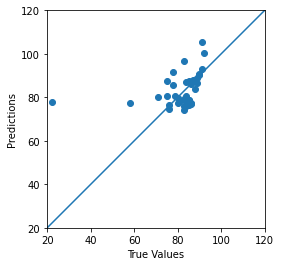

In [ ]:
a = plt.axes(aspect='equal')
plt.scatter(y_test, model_1.predict(X_test))
plt.xlabel('True Values')
plt.ylabel('Predictions')
lims = [20, 120]
plt.xlim(lims)
plt.ylim(lims)
ideal_line = plt.plot(lims, lims)